In [2]:
import cv2
import numpy as np
import pandas as pd
from keras.layers import Cropping2D
from scipy import ndimage
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

factor = 1.0 / 4.0

def resize(image):
    return cv2.resize(image, dsize=None, fx=factor, fy=factor)


def preprocess(image):
    return resize(image)


def create_Cropping2D():
    return Cropping2D(cropping=((int(70 * factor), int(25 * factor)), (0, 0)))


def get_input_shape():
    width = 800
    height = 600
    return (int(height * factor), int(width * factor), 3)


def get_images_and_measurements():
    def read_and_preprocess(image_file):
        return preprocess(ndimage.imread(image_file))
    
    items = ['images/img_0001_RED.jpg', 'images/img_0002_RED.jpg', 'images/img_0168_GREEN.jpg', 'images/img_0205_NO_TRAFFIC_LIGHT.jpg']
    images = list(map(read_and_preprocess, items))
    # encode class values as integers
    encoder = LabelEncoder()
    Y = ['RED', 'RED', 'GREEN', 'NO_TRAFFIC_LIGHT']
    encoder.fit(Y)
    encoded_Y = encoder.transform(Y)
    return images, np_utils.to_categorical(encoded_Y, 3)

def flip_image(image):
    return np.fliplr(image)


def flip_measurement(measurement):
    return -measurement


def flip_images(images):
    return map(flip_image, images)


def flip_measurements(measurements):
    return map(flip_measurement, measurements)


def get_steering_left(steering_center):
    return steering_center + 0.2


def get_steering_right(steering_center):
    return steering_center - 0.2

In [11]:
import numpy as np
from keras.callbacks import ModelCheckpoint
from keras.layers import Flatten, Dense, Lambda, MaxPooling2D
from keras.layers.convolutional import Convolution2D
from keras.models import Sequential

def get_X_train_y_train():
    images, measurements = get_images_and_measurements()
    X_train = np.array(images)
    y_train = np.array(measurements)
    return X_train, y_train


def create_model_simple():
    model = Sequential()
    model.add(Flatten(input_shape=get_input_shape()))
    model.add(Dense(3, activation="softmax"))
    return model


def create_model_LeNet():
    model = Sequential()
    model.add(Lambda(lambda image: image / 255.0 - 0.5, input_shape=get_input_shape()))
    model.add(create_Cropping2D())
    model.add(Convolution2D(6, 5, 5, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Convolution2D(6, 5, 5, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(120))
    model.add(Dense(84))
    model.add(Dense(3, activation="softmax"))
    return model


def create_model_Nvidia():
    model = Sequential()
    model.add(Lambda(lambda image: image / 255.0 - 0.5, input_shape=get_input_shape()))
    model.add(create_Cropping2D())
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), activation='relu'))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dense(50))
    model.add(Dense(10))
    model.add(Dense(3, activation="softmax"))
    return model


def train(model, X, y, save_model_2_file):
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history_object = model.fit(X,
                               y,
                               validation_split=0.2,
                               shuffle=True,
                               callbacks=[ModelCheckpoint(filepath=save_model_2_file, verbose=1, save_best_only=True)],
                               epochs=5,
                               verbose=1)
    return history_object

In [12]:
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

In [13]:
def plot_model(model, to_file):
    from keras.utils import plot_model
    from IPython.display import Image
    plot_model(model, show_shapes=True, show_layer_names=False, rankdir='TB', to_file=to_file)
    return Image(filename=to_file)

/home/frankknoll/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:40: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), strides=(2, 2), activation="relu")`
/home/frankknoll/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:41: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
/home/frankknoll/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:42: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`


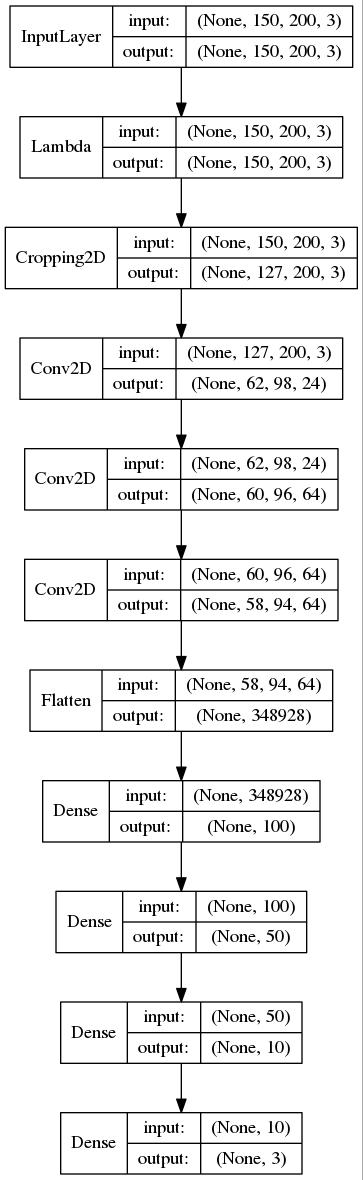

In [14]:
model = create_model_Nvidia()
plot_model(model, "examples/model_nvidia.jpg")

/home/frankknoll/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  


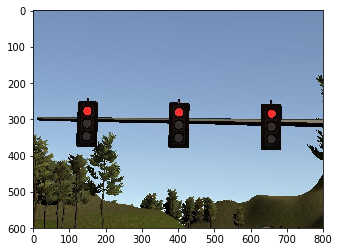

/home/frankknoll/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  # This is added back by InteractiveShellApp.init_path()


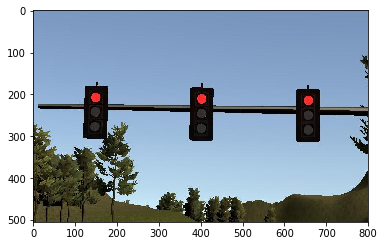

/home/frankknoll/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  app.launch_new_instance()


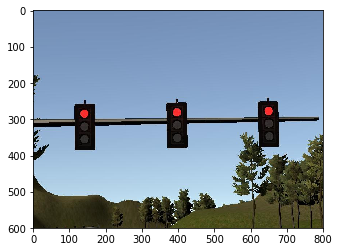

/home/frankknoll/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


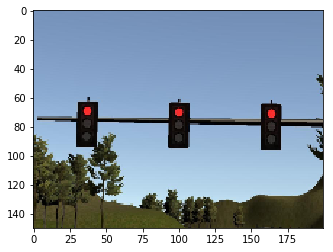

In [15]:
import numpy as np
from scipy import ndimage
from scipy.misc import imsave
from preprocess import preprocess

image = ndimage.imread('images/img_0001_RED.jpg')
plt.imshow(image)
plt.show()

cropped_image = image[70:, :][:-25, :]
imsave('examples/center_2016_12_01_13_31_15_308_cropped.jpg', cropped_image)
plt.imshow(cropped_image)
plt.show()

image_flipped = np.fliplr(image)
imsave('examples/center_2016_12_01_13_31_15_308_flipped.jpg', image_flipped)
plt.imshow(image_flipped)
plt.show()

preprocessed_image = preprocess(image)
plt.imshow(preprocessed_image)
imsave('examples/center_2016_12_01_13_31_15_308_quartered.jpg', preprocessed_image)
plt.show()

In [16]:
def plot_loss(history_object, savefile):
    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.savefig(savefile)
    plt.show()

In [17]:
X_train, y_train = get_X_train_y_train()

/home/frankknoll/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


In [18]:
y_train

array([[ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.]])

In [19]:
def train_and_plot(model, X, y, save_model_2_file, save_fig_2_file):
    history_object = train(model, X, y, save_model_2_file)
    plot_loss(history_object, save_fig_2_file)
    print("minimal validation loss: {:.5f}".format(min(history_object.history['val_loss'])))

Train on 3 samples, validate on 1 samples
Epoch 1/5
Epoch 00001: val_loss improved from inf to 16.11810, saving model to model_simple.h5
3/3 [==============================] - 0s 152ms/step - loss: 10.7454 - acc: 0.3333 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 2/5
Epoch 00002: val_loss did not improve
3/3 [==============================] - 0s 2ms/step - loss: 10.7454 - acc: 0.3333 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 3/5
Epoch 00003: val_loss did not improve
3/3 [==============================] - 0s 2ms/step - loss: 10.7454 - acc: 0.3333 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 4/5
Epoch 00004: val_loss did not improve
3/3 [==============================] - 0s 2ms/step - loss: 10.7454 - acc: 0.3333 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 5/5
Epoch 00005: val_loss did not improve
3/3 [==============================] - 0s 2ms/step - loss: 10.7454 - acc: 0.3333 - val_loss: 16.1181 - val_acc: 0.0000e+00


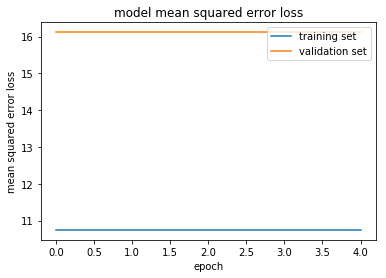

minimal validation loss: 16.11810


In [20]:
train_and_plot(create_model_simple(), X_train, y_train, save_model_2_file='model_simple.h5', save_fig_2_file='examples/loss_model_simple.png')

/home/frankknoll/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (5, 5), activation="relu")`
/home/frankknoll/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (5, 5), activation="relu")`


Train on 3 samples, validate on 1 samples
Epoch 1/5
Epoch 00001: val_loss improved from inf to 5.24174, saving model to model_lenet.h5
3/3 [==============================] - 0s 112ms/step - loss: 1.1813 - acc: 0.0000e+00 - val_loss: 5.2417 - val_acc: 0.0000e+00
Epoch 2/5
Epoch 00002: val_loss did not improve
3/3 [==============================] - 0s 20ms/step - loss: 0.0215 - acc: 1.0000 - val_loss: 9.2135 - val_acc: 0.0000e+00
Epoch 3/5
Epoch 00003: val_loss did not improve
3/3 [==============================] - 0s 20ms/step - loss: 3.0710e-04 - acc: 1.0000 - val_loss: 12.9002 - val_acc: 0.0000e+00
Epoch 4/5
Epoch 00004: val_loss did not improve
3/3 [==============================] - 0s 21ms/step - loss: 6.3380e-06 - acc: 1.0000 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 5/5
Epoch 00005: val_loss did not improve
3/3 [==============================] - 0s 20ms/step - loss: 1.9868e-07 - acc: 1.0000 - val_loss: 16.1181 - val_acc: 0.0000e+00


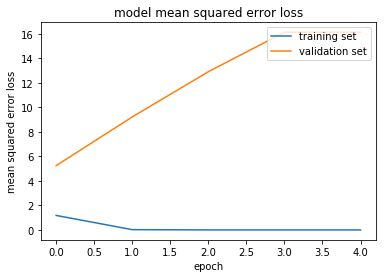

minimal validation loss: 5.24174


In [21]:
train_and_plot(create_model_LeNet(), X_train, y_train, 'model_lenet.h5', save_fig_2_file='examples/loss_model_lenet.png')

/home/frankknoll/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:40: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), strides=(2, 2), activation="relu")`
/home/frankknoll/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:41: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
/home/frankknoll/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:42: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`


Train on 3 samples, validate on 1 samples
Epoch 1/5
Epoch 00001: val_loss improved from inf to 16.11810, saving model to model_nvidia.h5
3/3 [==============================] - 3s 997ms/step - loss: 1.1345 - acc: 0.3333 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 2/5
Epoch 00002: val_loss did not improve
3/3 [==============================] - 1s 223ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 3/5
Epoch 00003: val_loss did not improve
3/3 [==============================] - 0s 159ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 4/5
Epoch 00004: val_loss did not improve
3/3 [==============================] - 0s 159ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 5/5
Epoch 00005: val_loss did not improve
3/3 [==============================] - 0s 155ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 16.1181 - val_acc: 0.0000e+00


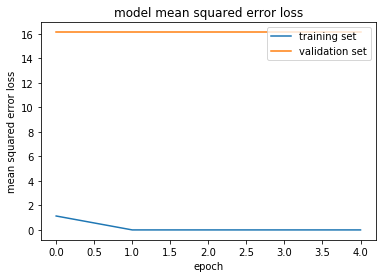

minimal validation loss: 16.11810


In [22]:
train_and_plot(create_model_Nvidia(), X_train, y_train, 'model_nvidia.h5', save_fig_2_file='examples/loss_model_nvidia.png')